In [33]:
# ============================================================================
# CELL 1: IMPORTS & SETUP
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print(f"✅ TensorFlow version: {tf.__version__}")
print("✅ All imports successful!")

✅ TensorFlow version: 2.20.0
✅ All imports successful!


In [34]:
# ============================================================================
# CELL 2: LOAD DATA
# ============================================================================
df = pd.read_csv(r'C:\Users\aksha\coading\New folder (2)\data\recent\5_batteries.csv')

print("="*60)
print("📊 DATA LOADED")
print("="*60)
print(f"Total samples: {len(df)}")
print(f"Batteries: {df['Battery_ID'].unique()}")
print(f"Columns: {len(df.columns)}")
print(f"\nFirst few rows:")
print(df.head(3))

📊 DATA LOADED
Total samples: 616
Batteries: ['B0005' 'B0006' 'B0007' 'B0018']
Columns: 31

First few rows:
   Cycle  Voltage_measured  Current_measured  Temperature_measured  \
0     11          3.541335         -1.816811             32.434182   
1     13          3.541025         -1.816791             32.480416   
2     15          3.554133         -1.844341             32.410462   

          Time  Capacity Battery_ID  capacity_fade_total  \
0  1793.497759  1.835662      B0005             0.020826   
1  1792.842246  1.835146      B0005             0.021341   
2  1756.570764  1.825757      B0005             0.030731   

   capacity_fade_percent  capacity_rolling_mean_5  ...  energy_discharged  \
0               1.121783                 1.837449  ...           6.500692   
1               1.149551                 1.835213  ...           6.498298   
2               1.655310                 1.833295  ...           6.488983   

   power_avg  voltage_efficiency  discharge_capacity_ratio  \


In [ ]:
# ============================================================================
# CELL 3: DEFINE CLEAN FEATURES (NO DATA LEAKAGE)
# ============================================================================

# These are the features we EXCLUDE (same as XGBoost project)
EXCLUDE = [
    'Cycle', 'Time', 'Capacity', 'Battery_ID',
    'capacity_fade_total', 'capacity_fade_percent',
    'discharge_capacity_ratio', 'remaining_capacity',
    'capacity_rolling_mean_5', 'capacity_rolling_std_5',
    'energy_discharged', 'voltage_capacity_ratio',
    'power_to_energy_ratio',
]

# Get clean features
# n_features = [col for col in df.columns if col not in EXCLUDE]
n_features = [
    'cycle_normalized',
    'capacity_velocity', 
    'internal_resistance',
    'voltage_rolling_mean_5',
    'temp_rolling_mean_5'
]

print("="*60)
print(f"✅ USING {len(n_features)} CLEAN FEATURES")
print("="*60)
for i, feat in enumerate(n_features, 1):
    print(f"{i:2d}. {feat}")

✅ USING 18 CLEAN FEATURES
 1. Voltage_measured
 2. Current_measured
 3. Temperature_measured
 4. capacity_trend_5
 5. voltage_rolling_mean_5
 6. temp_rolling_mean_5
 7. capacity_velocity
 8. capacity_acceleration
 9. cycle_normalized
10. cycles_from_start
11. voltage_change
12. resistance_proxy
13. internal_resistance
14. power_avg
15. voltage_efficiency
16. temp_capacity_interaction
17. degradation_acceleration_abs
18. estimated_cycles_to_eol


In [36]:
# ============================================================================
# CELL 4: LSTM CONFIGURATION
# ============================================================================

# THESE ARE THE KEY PARAMETERS - You can adjust them!
LOOKBACK = 20      # How many past cycles to look at
HORIZON = 10       # How many future cycles to predict

print("="*60)
print("⚙️ LSTM CONFIGURATION")
print("="*60)
print(f"Lookback window: {LOOKBACK} cycles (input)")
print(f"Prediction horizon: {HORIZON} cycles (output)")
print(f"Features per timestep: {len(n_features)}")
print(f"\nExample:")
print(f"  Input: Cycles 30-49 (20 cycles × {len(n_features)} features)")
print(f"  Output: Capacity for cycles 50-59 (10 values)")

⚙️ LSTM CONFIGURATION
Lookback window: 20 cycles (input)
Prediction horizon: 10 cycles (output)
Features per timestep: 18

Example:
  Input: Cycles 30-49 (20 cycles × 18 features)
  Output: Capacity for cycles 50-59 (10 values)


In [37]:
# ============================================================================
# CELL 5: FUNCTION TO CREATE SEQUENCES
# ============================================================================

def create_sequences(battery_df, features, lookback, horizon):
    """
    Create sliding window sequences for LSTM
    
    Think of it like this:
    - Take cycles 1-20 → predict cycles 21-30
    - Take cycles 2-21 → predict cycles 22-31
    - Take cycles 3-22 → predict cycles 23-32
    ... and so on (sliding window)
    
    Args:
        battery_df: DataFrame for one battery
        features: List of feature names
        lookback: How many past cycles to use
        horizon: How many future cycles to predict
    
    Returns:
        X: Input sequences (samples, lookback, features)
        y: Output targets (samples, horizon)
    """
    X_sequences = []
    y_sequences = []
    
    # Sort by cycle to ensure temporal order
    battery_df = battery_df.sort_values('Cycle').reset_index(drop=True)
    
    # Extract feature matrix and target
    X_data = battery_df[features].values  # Shape: (n_cycles, n_features)
    y_data = battery_df['Capacity'].values  # Shape: (n_cycles,)
    
    # Sliding window approach
    for i in range(len(battery_df) - lookback - horizon + 1):
        # Input sequence: cycles [i : i+lookback]
        X_seq = X_data[i : i + lookback]
        
        # Output sequence: next [horizon] capacity values
        y_seq = y_data[i + lookback : i + lookback + horizon]
        
        X_sequences.append(X_seq)
        y_sequences.append(y_seq)
    
    return np.array(X_sequences), np.array(y_sequences)

print("✅ Sequence creation function defined!")
print("\nThis function will convert your battery data into:")
print(f"  X shape: (n_sequences, {LOOKBACK}, {len(n_features)})")
print(f"  y shape: (n_sequences, {HORIZON})")

✅ Sequence creation function defined!

This function will convert your battery data into:
  X shape: (n_sequences, 20, 18)
  y shape: (n_sequences, 10)


In [38]:
# ============================================================================
# CELL 5: FUNCTION TO CREATE SEQUENCES
# ============================================================================

def create_sequences(battery_df, features, lookback, horizon):
    """
    Create sliding window sequences for LSTM
    
    Think of it like this:
    - Take cycles 1-20 → predict cycles 21-30
    - Take cycles 2-21 → predict cycles 22-31
    - Take cycles 3-22 → predict cycles 23-32
    ... and so on (sliding window)
    
    Args:
        battery_df: DataFrame for one battery
        features: List of feature names
        lookback: How many past cycles to use
        horizon: How many future cycles to predict
    
    Returns:
        X: Input sequences (samples, lookback, features)
        y: Output targets (samples, horizon)
    """
    X_sequences = []
    y_sequences = []
    
    # Sort by cycle to ensure temporal order
    battery_df = battery_df.sort_values('Cycle').reset_index(drop=True)
    
    # Extract feature matrix and target
    X_data = battery_df[features].values  # Shape: (n_cycles, n_features)
    y_data = battery_df['Capacity'].values  # Shape: (n_cycles,)
    
    # Sliding window approach
    for i in range(len(battery_df) - lookback - horizon + 1):
        # Input sequence: cycles [i : i+lookback]
        X_seq = X_data[i : i + lookback]
        
        # Output sequence: next [horizon] capacity values
        y_seq = y_data[i + lookback : i + lookback + horizon]
        
        X_sequences.append(X_seq)
        y_sequences.append(y_seq)
    
    return np.array(X_sequences), np.array(y_sequences)

print("✅ Sequence creation function defined!")
print("\nThis function will convert your battery data into:")
print(f"  X shape: (n_sequences, {LOOKBACK}, {len(n_features)})")
print(f"  y shape: (n_sequences, {HORIZON})")

✅ Sequence creation function defined!

This function will convert your battery data into:
  X shape: (n_sequences, 20, 18)
  y shape: (n_sequences, 10)


In [39]:
# ============================================================================
# CELL 6: CREATE TRAINING SEQUENCES (3 BATTERIES)
# ============================================================================

train_batteries = ['B0005', 'B0006', 'B0007']

print("="*60)
print("🔧 CREATING TRAINING SEQUENCES")
print("="*60)

X_train_list = []
y_train_list = []

for battery_id in train_batteries:
    # Get data for this battery
    battery_df = df[df['Battery_ID'] == battery_id]
    
    # Create sequences
    X_seq, y_seq = create_sequences(battery_df, n_features, LOOKBACK, HORIZON)
    
    print(f"\n{battery_id}:")
    print(f"  Total cycles: {len(battery_df)}")
    print(f"  Sequences created: {len(X_seq)}")
    print(f"  X shape: {X_seq.shape}")
    print(f"  y shape: {y_seq.shape}")
    
    X_train_list.append(X_seq)
    y_train_list.append(y_seq)

# Combine all batteries
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

print("\n" + "="*60)
print(f"✅ TOTAL TRAINING DATA:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print("="*60)

🔧 CREATING TRAINING SEQUENCES

B0005:
  Total cycles: 163
  Sequences created: 134
  X shape: (134, 20, 18)
  y shape: (134, 10)

B0006:
  Total cycles: 163
  Sequences created: 134
  X shape: (134, 20, 18)
  y shape: (134, 10)

B0007:
  Total cycles: 163
  Sequences created: 134
  X shape: (134, 20, 18)
  y shape: (134, 10)

✅ TOTAL TRAINING DATA:
   X_train: (402, 20, 18)
   y_train: (402, 10)


In [40]:
# ============================================================================
# CELL 7: CREATE TEST SEQUENCES (UNSEEN BATTERY B0018)
# ============================================================================

print("="*60)
print("🧪 CREATING TEST SEQUENCES")
print("="*60)

test_battery_df = df[df['Battery_ID'] == 'B0018']
X_test, y_test = create_sequences(test_battery_df, n_features, LOOKBACK, HORIZON)

print(f"\nB0018 (Test Battery - UNSEEN):")
print(f"  Total cycles: {len(test_battery_df)}")
print(f"  Sequences created: {len(X_test)}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

print("\n✅ Test data ready!")
print("="*60)

🧪 CREATING TEST SEQUENCES

B0018 (Test Battery - UNSEEN):
  Total cycles: 127
  Sequences created: 98
  X_test: (98, 20, 18)
  y_test: (98, 10)

✅ Test data ready!


In [41]:
# ============================================================================
# FIX #1: SCALE BOTH X AND Y (CORRECTED)
# ============================================================================

from sklearn.preprocessing import StandardScaler

# First, get the correct dimensions
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
n_timesteps = X_train.shape[1]  # Should be 20 (LOOKBACK)
n_features = X_train.shape[2]   # Should be 18 (number of features)

print("="*60)
print("📊 DATA DIMENSIONS")
print("="*60)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape:  {y_test.shape}")
print(f"\nn_samples_train: {n_samples_train}")
print(f"n_samples_test:  {n_samples_test}")
print(f"n_timesteps:     {n_timesteps}")
print(f"n_features:      {n_features}")

# Scale features (X)
print("\n🔄 Scaling X...")
scaler_X = StandardScaler()
X_train_2d = X_train.reshape(-1, n_features)
X_test_2d = X_test.reshape(-1, n_features)

X_train_scaled = scaler_X.fit_transform(X_train_2d)
X_test_scaled = scaler_X.transform(X_test_2d)

X_train_scaled = X_train_scaled.reshape(n_samples_train, n_timesteps, n_features)
X_test_scaled = X_test_scaled.reshape(n_samples_test, n_timesteps, n_features)

print(f"✅ X scaled!")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled:  {X_test_scaled.shape}")

# Scale target (y) - THIS IS THE KEY FIX!
print("\n🔄 Scaling y...")
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print(f"✅ y scaled!")
print(f"   y_train_scaled: {y_train_scaled.shape}")
print(f"   y_test_scaled:  {y_test_scaled.shape}")

print("\n" + "="*60)
print("✅ BOTH X AND Y SCALED SUCCESSFULLY!")
print("="*60)
print(f"\nOriginal y_train range: {y_train.min():.3f} to {y_train.max():.3f}")
print(f"Scaled y_train range:   {y_train_scaled.min():.3f} to {y_train_scaled.max():.3f}")

📊 DATA DIMENSIONS
X_train shape: (402, 20, 18)
X_test shape:  (98, 20, 18)
y_train shape: (402, 10)
y_test shape:  (98, 10)

n_samples_train: 402
n_samples_test:  98
n_timesteps:     20
n_features:      18

🔄 Scaling X...
✅ X scaled!
   X_train_scaled: (402, 20, 18)
   X_test_scaled:  (98, 20, 18)

🔄 Scaling y...
✅ y scaled!
   y_train_scaled: (402, 10)
   y_test_scaled:  (98, 10)

✅ BOTH X AND Y SCALED SUCCESSFULLY!

Original y_train range: 1.154 to 1.925
Scaled y_train range:   -2.218 to 2.301


In [42]:
# ============================================================================
# SIMPLER LSTM ARCHITECTURE
# ============================================================================

print("="*60)
print("🏗️ BUILDING SIMPLER LSTM MODEL")
print("="*60)

# Use SINGLE LSTM layer with fewer units
model = Sequential([
    # Single LSTM layer (not 2!)
    LSTM(32, return_sequences=False, input_shape=(LOOKBACK, n_features)),
    Dropout(0.3),  # More dropout to prevent overfitting
    
    # Direct output
    Dense(HORIZON, activation='linear')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate
    loss='mse',
    metrics=['mae']
)

print(model.summary())
print("\n✅ Simpler model built!")
print("   32 LSTM units (was 128→64)")
print("   Dropout 0.3 (was 0.2)")
print("   Lower LR: 0.0005 (was 0.001)")
print("="*60)

🏗️ BUILDING SIMPLER LSTM MODEL


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 32)             │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,858 (26.79 KB)

 Trainable params: 6,858 (26.79 KB)

 Non-trainable params: 0 (0.00 B)

None

✅ Simpler model built!
   32 LSTM units (was 128→64)
   Dropout 0.3 (was 0.2)
   Lower LR: 0.0005 (was 0.001)


In [43]:
# ============================================================================
# CELL 10: DEFINE TRAINING CALLBACKS
# ============================================================================

# Early Stopping: Stop if validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',           # Watch validation loss
    patience=20,                  # Stop if no improvement for 20 epochs
    restore_best_weights=True,    # Load best weights at end
    verbose=1
)

# Learning Rate Reduction: Reduce LR when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                   # Multiply LR by 0.5
    patience=10,                  # Wait 10 epochs before reducing
    min_lr=0.00001,              # Don't go below this
    verbose=1
)

print("✅ Callbacks defined:")
print("   • Early Stopping (patience=20)")
print("   • Learning Rate Reduction (patience=10)")

✅ Callbacks defined:
   • Early Stopping (patience=20)
   • Learning Rate Reduction (patience=10)


In [44]:
# ============================================================================
# CELL 11: TRAIN LSTM MODEL (CRITICAL FIX!)
# ============================================================================

print("="*60)
print("🚀 TRAINING LSTM MODEL")
print("="*60)
print("This may take 5-10 minutes... ☕")
print("")

history = model.fit(
    X_train_scaled, y_train_scaled,  # ✅ USE SCALED Y!
    validation_split=0.2,             # Use 20% of training for validation
    epochs=100,                       # Max epochs (early stopping may stop sooner)
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1                         # Show progress
)

print("\n✅ Training complete!")
print("="*60)

🚀 TRAINING LSTM MODEL
This may take 5-10 minutes... ☕

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.1989 - mae: 0.9294 - val_loss: 0.1502 - val_mae: 0.3014 - learning_rate: 5.0000e-04
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9672 - mae: 0.8202 - val_loss: 0.1252 - val_mae: 0.2633 - learning_rate: 5.0000e-04
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7718 - mae: 0.7125 - val_loss: 0.1028 - val_mae: 0.2276 - learning_rate: 5.0000e-04
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6301 - mae: 0.6263 - val_loss: 0.0835 - val_mae: 0.2006 - learning_rate: 5.0000e-04
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5228 - mae: 0.5640 - val_loss: 0.0704 - val_mae: 0.1872 - learning_rate: 5.0000e-04
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4507 - mae: 0.5140 - val_loss: 0.0619 - val_mae: 0.1810 - learning_rate: 5.0000e-04
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3808 - mae: 0

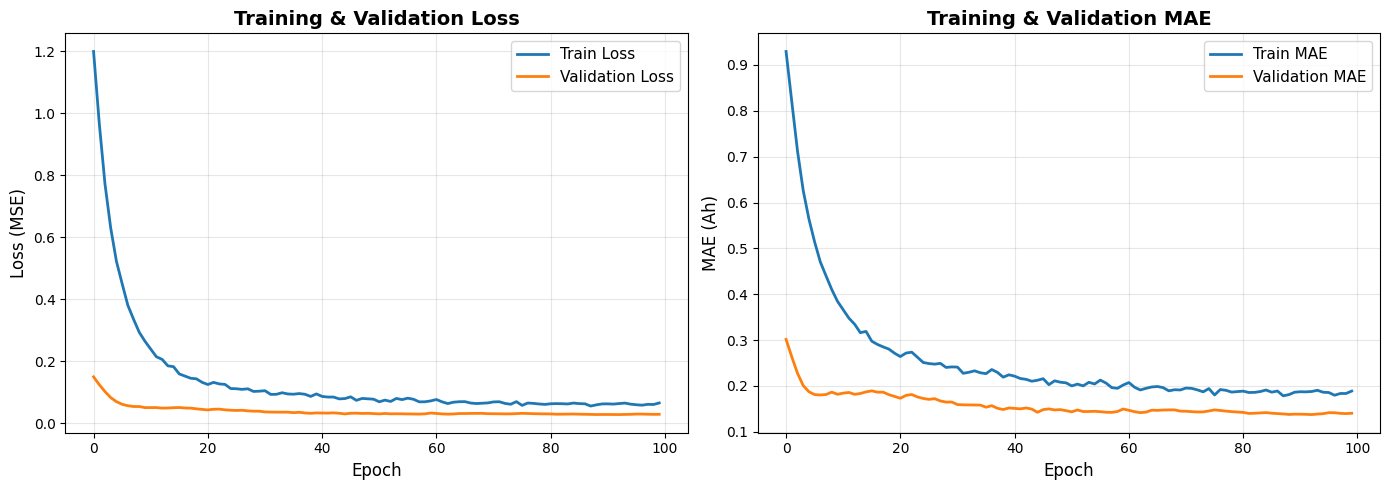

✅ Training history saved as 'lstm_training_history.png'


In [45]:
# ============================================================================
# CELL 12: VISUALIZE TRAINING HISTORY
# ============================================================================

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Plot 2: MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE (Ah)', fontsize=12)
plt.title('Training & Validation MAE', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training history saved as 'lstm_training_history.png'")

In [46]:
# ============================================================================
# EVALUATE ON TEST SET (WITH INVERSE SCALING!)
# ============================================================================

print("="*60)
print("🔮 MAKING PREDICTIONS")
print("="*60)

# Predict on SCALED data
y_pred_train_scaled = model.predict(X_train_scaled, verbose=0)
y_pred_test_scaled = model.predict(X_test_scaled, verbose=0)

# INVERSE TRANSFORM back to original scale
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)

print(f"✅ Predictions generated and inverse-transformed!")
print(f"   y_pred_train: {y_pred_train.shape}")
print(f"   y_pred_test:  {y_pred_test.shape}")

# Flatten for overall metrics
y_train_flat = y_train.flatten()
y_pred_train_flat = y_pred_train.flatten()
y_test_flat = y_test.flatten()
y_pred_test_flat = y_pred_test.flatten()

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_flat, y_pred_train_flat))
train_mae = mean_absolute_error(y_train_flat, y_pred_train_flat)
train_r2 = r2_score(y_train_flat, y_pred_train_flat)

test_rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_test_flat))
test_mae = mean_absolute_error(y_test_flat, y_pred_test_flat)
test_r2 = r2_score(y_test_flat, y_pred_test_flat)

print("\n" + "="*60)
print("📊 MODEL EVALUATION")
print("="*60)

print("\n🎓 TRAIN SET (3 Batteries):")
print(f"   RMSE: {train_rmse:.4f} Ah")
print(f"   MAE:  {train_mae:.4f} Ah")
print(f"   R²:   {train_r2:.4f}")

print("\n🧪 TEST SET (Unseen Battery B0018):")
print(f"   RMSE: {test_rmse:.4f} Ah")
print(f"   MAE:  {test_mae:.4f} Ah")
print(f"   R²:   {test_r2:.4f}")

# Per-step accuracy
print("\n📉 ACCURACY PER PREDICTION STEP:")
print("    Step | MAE (Ah) | RMSE (Ah)")
print("    " + "-"*35)

for step in range(HORIZON):
    step_mae = mean_absolute_error(y_test[:, step], y_pred_test[:, step])
    step_rmse = np.sqrt(mean_squared_error(y_test[:, step], y_pred_test[:, step]))
    print(f"    +{step+1:2d}   | {step_mae:.4f}   | {step_rmse:.4f}")

# Verdict
print("\n" + "="*60)
if test_r2 >= 0.75:
    print("🌟 EXCELLENT - Test R² >= 0.75!")
elif test_r2 >= 0.65:
    print("✅ GOOD - Test R² >= 0.65!")
elif test_r2 >= 0.50:
    print("⚠️ ACCEPTABLE - Test R² >= 0.50")
else:
    print("❌ NEEDS MORE WORK - Test R² < 0.50")

print(f"\nTest R² = {test_r2:.4f}")
print("="*60)

🔮 MAKING PREDICTIONS
✅ Predictions generated and inverse-transformed!
   y_pred_train: (402, 10)
   y_pred_test:  (98, 10)

📊 MODEL EVALUATION

🎓 TRAIN SET (3 Batteries):
   RMSE: 0.0245 Ah
   MAE:  0.0180 Ah
   R²:   0.9794

🧪 TEST SET (Unseen Battery B0018):
   RMSE: 0.1197 Ah
   MAE:  0.1100 Ah
   R²:   -0.1677

📉 ACCURACY PER PREDICTION STEP:
    Step | MAE (Ah) | RMSE (Ah)
    -----------------------------------
    + 1   | 0.1541   | 0.1572
    + 2   | 0.1197   | 0.1249
    + 3   | 0.0806   | 0.0870
    + 4   | 0.1161   | 0.1214
    + 5   | 0.1127   | 0.1217
    + 6   | 0.0672   | 0.0757
    + 7   | 0.1130   | 0.1201
    + 8   | 0.0865   | 0.0955
    + 9   | 0.1008   | 0.1074
    +10   | 0.1492   | 0.1582

❌ NEEDS MORE WORK - Test R² < 0.50

Test R² = -0.1677
